### EDA
#### Step 1 : 分析各產業別之間的異常報酬率

In [19]:
import pandas as pd
import seaborn as sns
import bokeh as bok
df_fs_return=pd.read_csv("上市櫃公司_plus異常報酬率.csv")

In [20]:
import numpy as np
df_fs_return_columns=df_fs_return.columns[51:]
return_industry=df_fs_return.groupby(by="TSE產業名稱")[df_fs_return_columns].mean()
print("資料集大小 :",return_industry.shape)
print(f"總計有{len(np.unique(df_fs_return['TSE產業名稱'].values.flatten()))}種產業類別")

資料集大小 : (35, 132)
總計有35種產業類別


### 動態圖表 : 完全由Gemini pro 3 製作

#### df.melt() = 將寬資料轉換成長資料，以符合製圖模組的需求
#### 使用說明 :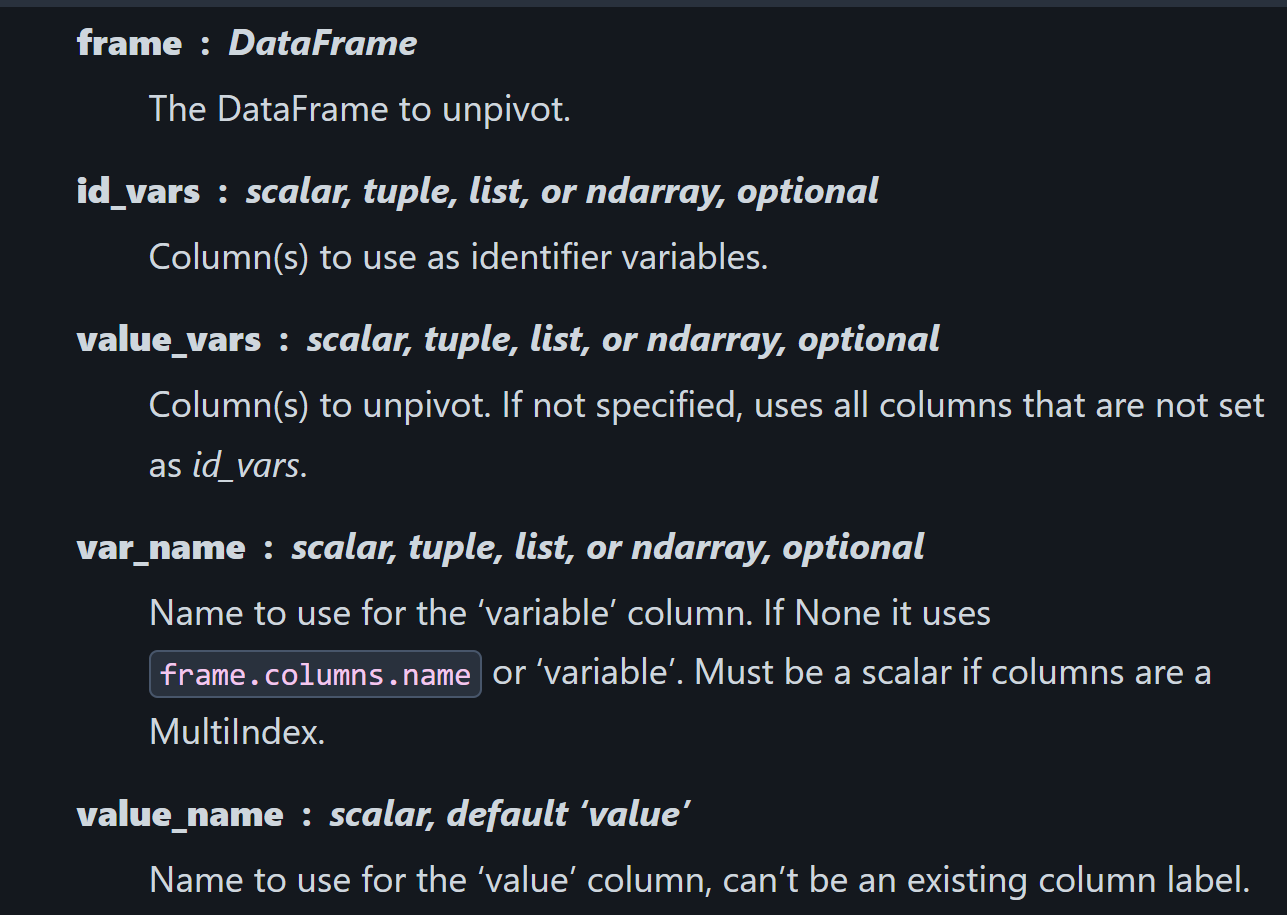
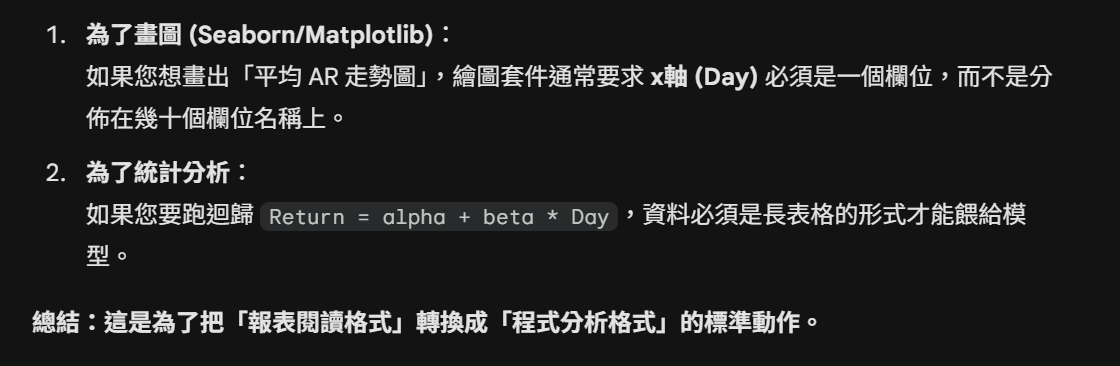
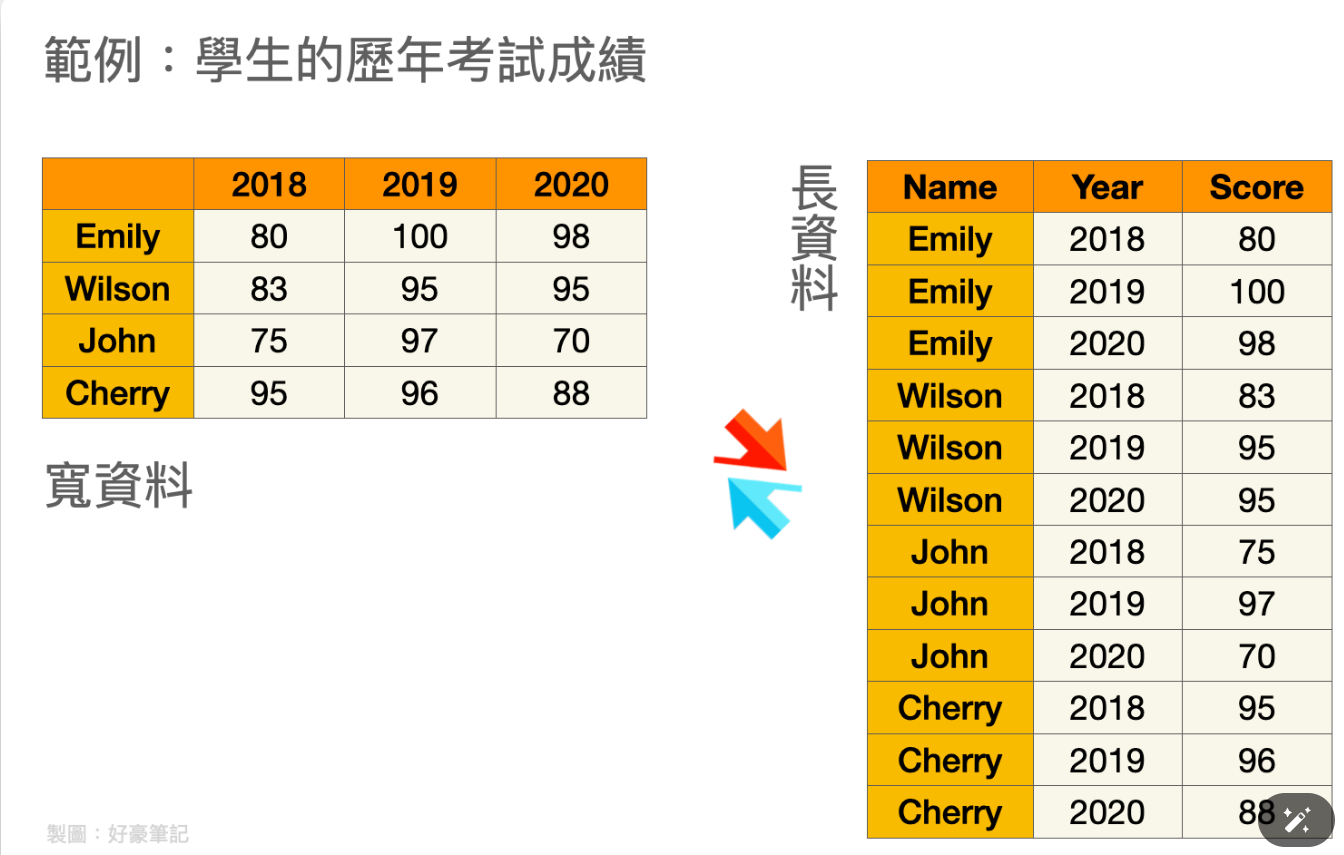
#### <span style="color : #2c5344"> px.colors.qualitative函式內容:
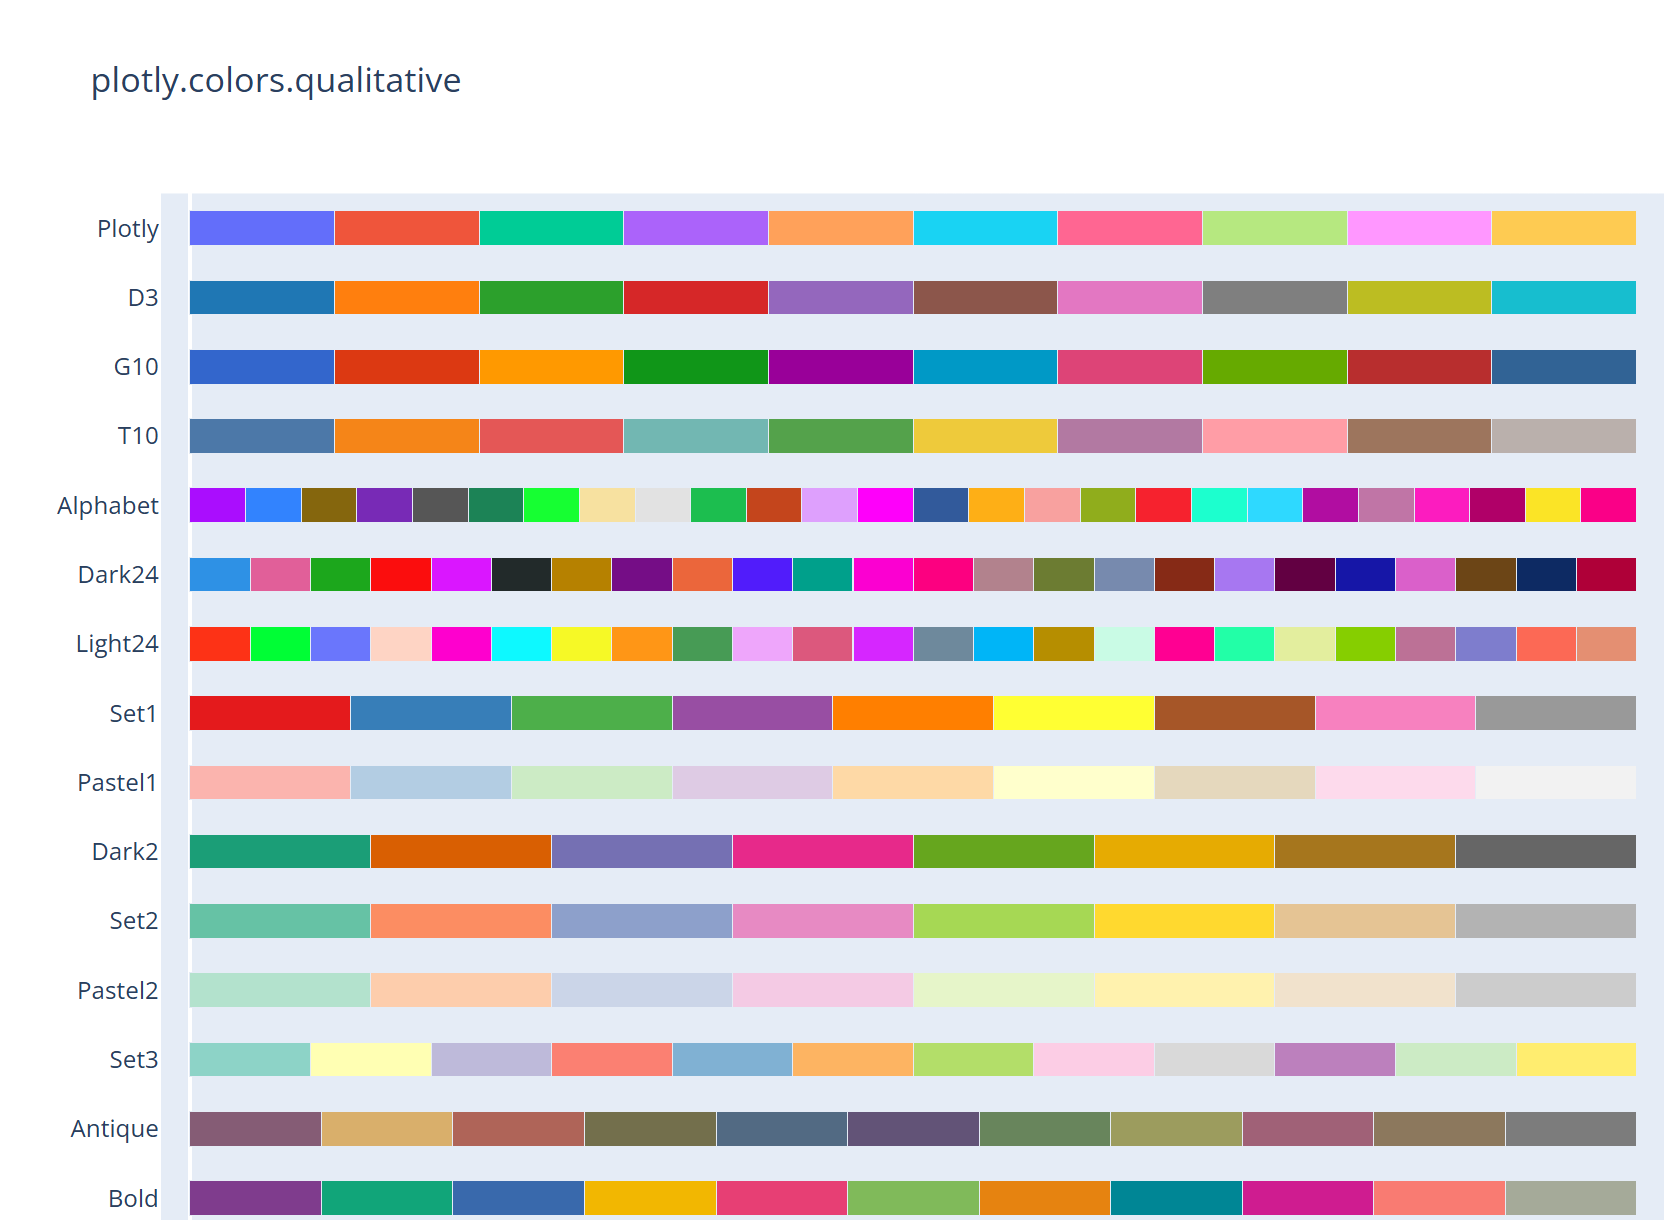

In [ ]:
import pandas as pd
import plotly.express as px
import numpy as np

# 1. 讀取資料
df = pd.read_csv('return_industry.csv')

# 清除可能存在的雜訊欄位
if 'Unnamed: 182' in df.columns:
    df = df.drop(columns=['Unnamed: 182'])

if '平均值' in df.columns:
    df = df.drop(columns=['平均值'])

# 2. 資料轉置：從 Wide Format 轉為 Long Format
# id_vars 是固定欄位 (產業名稱)，其餘欄位都是時間點
id_col = df.columns[0]  # 'TSE產業名稱'
time_cols = df.columns[1:]  # '-10', '-9', ... 等時間欄位

df_long = df.melt(id_vars=[id_col], value_vars=time_cols, var_name='Day', value_name='Return')

# 3. 資料清理：將天數轉為整數並排序
df_long['Day'] = df_long['Day'].astype(int)
df_long = df_long.sort_values(by=[id_col, 'Day'])

# 4. 計算累積報酬 (Trend Growth 的核心)
df_long['Cumulative_Return'] = df_long.groupby(id_col)['Return'].cumsum()

# 5. 製作動畫專用的資料結構 (Data Inflation)
# 為了讓線條有「生長」的效果，每一個 Frame (時間點) 必須包含「過去所有的資料」
frames_data = []
unique_days = sorted(df_long['Day'].unique())

for day in unique_days:
    # 篩選出「目前時間點之前」的所有資料
    subset = df_long[df_long['Day'] <= day].copy()
    subset['Frame'] = day  # 設定動畫的時間軸標記
    frames_data.append(subset)

# 合併所有 Frame 的資料 (這會使資料量變大，但能確保動畫流暢)
animated_df = pd.concat(frames_data)

distinct_colors = px.colors.qualitative.Alphabet + px.colors.qualitative.Dark24

# 6. 繪製動態折線圖 (加入 color_discrete_sequence)
fig = px.line(
    animated_df,
    x="Day",
    y="Cumulative_Return",
    color=id_col,
    animation_frame="Frame",
    title="各產業累積異常報酬率動態趨勢圖",
    labels={"Cumulative_Return": "Cumulative Abnormal Return (%)", "Day": "Event Day"},
    range_x=[min(unique_days), max(unique_days)],
    range_y=[df_long['Cumulative_Return'].min()*1.1, df_long['Cumulative_Return'].max()*1.1],
    
    # ★ 關鍵修改在這裡：指定自訂的超長色票
    color_discrete_sequence=distinct_colors
)

# 優化版面 (建議把 Legend 字體縮小，以免遮住圖表)
fig.update_layout(
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    hovermode="x unified",
    legend=dict(
        font=dict(size=9), # 縮小圖例字體
        itemwidth=30       # 縮窄圖例寬度
    ),
    updatemenus=[dict(type='buttons', showactive=False,
                                buttons=[dict(label='Play',
                                            method='animate',
                                            args=[None, dict(frame=dict(duration=50, redraw=True), fromcurrent=True)])])]
)

fig.write_html("trend_growth_animation_v2.html")
print("已生成顏色改良版：trend_growth_animation_v2.html")

已生成顏色改良版：trend_growth_animation_v2.html


#### step 2 : 分別找出事件期內表現最好/最差的5個產業

#### 表現最好的5個產業 :  玻璃陶瓷 + 數位雲端 + 油電燃氣業 + 食品工業 + 農業科技
#### 表現最差的5個產業 :  存託憑證 (不太算產業吧) + 鋼鐵工業 + 通訊網路業 + 運動休閒 + 資訊服務業 + 汽車工業

In [12]:
if "Unnamed: 182" in return_industry.columns:
    return_industry=return_industry.drop(columns="Unnamed: 182")

if 0 in return_industry.columns:
    return_industry=return_industry.drop(columns=0)

return_industry_mean=return_industry.mean(axis=1)
return_industry["平均值"]=return_industry_mean
print("事件期內報酬率最高的5個產業:",return_industry_mean.sort_values(ascending=False).head().index)
print("事件期內報酬率最低的6個產業:",return_industry_mean.sort_values(ascending=True).head(6).index)



事件期內報酬率最高的5個產業: Index(['玻璃陶瓷', '數位雲端', '油電燃氣業', '食品工業', '農業科技'], dtype='object', name='TSE產業名稱')
事件期內報酬率最低的6個產業: Index(['存託憑證', '鋼鐵工業', '通訊網路業', '運動休閒', '資訊服務業', '汽車工業'], dtype='object', name='TSE產業名稱')


### 再針對最好以及最慘的產業製作動態累積報酬率變化圖

#### updatemenus 參數文件 : https://plotly.com/python/reference/layout/updatemenus/#layout-updatemenus

In [13]:
df_extreme_columns=['玻璃陶瓷', '數位雲端', '油電燃氣業', '食品工業', '農業科技','鋼鐵工業', '通訊網路業', '運動休閒', '資訊服務業', '汽車工業']
df_extreme=return_industry.loc[df_extreme_columns,:]

def plot_cumulative_return_animation(df, output_filename="trend_growth_animation.html", title="各產業累積異常報酬率動態趨勢圖"):
    """
    將寬表格格式的事件研究法資料，轉換為動態累積報酬率折線圖並輸出 HTML。
    
    參數:
    ----------
    df : pd.DataFrame
        原始寬表格資料。
        - 第 1 欄必須是 ID (如 'TSE產業名稱' 或 '公司代號')
        - 第 2 欄之後必須是時間序 (如 '-10', '-9', ... '0', '1' ...)
    output_filename : str
        輸出的 HTML 檔名 (預設: "trend_growth_animation.html")
    title : str
        圖表標題
        
    回傳:
    ----------
    fig : plotly.graph_objs._figure.Figure
        Plotly 的圖表物件 (可在 Jupyter Notebook 中直接顯示)
    """
    
    # 1. 自動辨識 ID 欄位與時間欄位
    id_col = df.columns[0]      # 抓取第一欄作為 ID (例如: 產業名稱)
    time_cols = df.columns[1:]  # 抓取其餘欄位作為時間 (例如: -10, -9...)
    
    print(f"正在處理資料... ID欄位: {id_col}, 時間欄位數: {len(time_cols)}")

    # 2. 寬轉長 (Melt)
    df_long = df.melt(id_vars=[id_col], value_vars=time_cols, var_name='Day', value_name='Return')

    # 3. 資料清理：轉整數並排序
    try:
        df_long['Day'] = df_long['Day'].astype(int)
    except ValueError:
        print("警告：時間欄位包含非數字字元，嘗試強制轉換...")
        # 這裡假設欄位是純數字字串，若有 'Day-1' 這種格式可能需要額外處理
        df_long['Day'] = pd.to_numeric(df_long['Day'], errors='coerce')
        
    df_long = df_long.sort_values(by=[id_col, 'Day'])

    # 4. 計算累積報酬 (CAR)
    # 注意：如果原本輸入的就已經是累積報酬，這一行會變成「累積的累積」，請確認輸入資料為「單日報酬」
    df_long['Cumulative_Return'] = df_long.groupby(id_col)['Return'].cumsum()

    # 5. 製作動畫資料結構 (Data Inflation)
    # 讓線條隨著 Frame 增加而變長，而不是只顯示單點
    frames_data = []
    unique_days = sorted(df_long['Day'].unique())

    print("正在生成動畫影格 (這可能需要一點時間)...")
    for day in unique_days:
        # 篩選出「目前時間點之前」的所有資料
        subset = df_long[df_long['Day'] <= day].copy()
        subset['Frame'] = day  # 設定動畫的時間軸標記
        frames_data.append(subset)

    # 合併資料
    animated_df = pd.concat(frames_data)

    # 定義色票 (避免顏色不夠用)
    distinct_colors = px.colors.qualitative.Alphabet + px.colors.qualitative.Dark24

    # 6. 繪圖
    fig = px.line(
        animated_df,
        x="Day",
        y="Cumulative_Return",
        color=id_col,
        animation_frame="Frame",
        title=title,
        labels={"Cumulative_Return": "Cumulative Abnormal Return (%)", "Day": "Event Day"},
        
        # 設定固定範圍，避免動畫播放時座標軸亂跳
        range_x=[min(unique_days), max(unique_days)],
        range_y=[df_long['Cumulative_Return'].min()*1.1, df_long['Cumulative_Return'].max()*1.1],
        
        # 指定色票
        color_discrete_sequence=distinct_colors
    )

    # 7. 優化版面
    fig.update_layout(
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        hovermode="x unified",
        legend=dict(
            font=dict(size=9),
            itemwidth=30
        ),
        # 設定播放按鈕參數
        updatemenus=[dict(
            type='buttons', 
            showactive=False,
            buttons=[dict(
                label='Play',
                method='animate',
                args=[None, dict(frame=dict(duration=50, redraw=True), fromcurrent=True)]
            )]
        )]
    )

    # 8. 輸出結果
    fig.write_html(output_filename)
    print(f"✅ 成功生成動畫圖表：{output_filename}")
    
    return fig

In [28]:
df_extreme=df_extreme.reset_index()

In [29]:
plot_cumulative_return_animation(df_extreme, output_filename="trend_growth_animation_extreme5.html", title="最好/糟產業累積異常報酬率動態趨勢圖")

正在處理資料... ID欄位: TSE產業名稱, 時間欄位數: 132
警告：時間欄位包含非數字字元，嘗試強制轉換...
正在生成動畫影格 (這可能需要一點時間)...
✅ 成功生成動畫圖表：trend_growth_animation_extreme5.html


#### 觀察表現最好 / 最差產業與EPU多寡之間的關聯

In [23]:
# 需加入axis=1 ，否則預設值會以axis=0運作 (-10平均, -9平均....)
df_extreme_return_EPU=df_extreme.mean(axis=1)
df_fs_extreme_EPU=df_fs_return[df_fs_return["TSE產業名稱"].isin(df_extreme_columns)]
df_fs_extreme_EPU=df_fs_extreme_EPU.groupby(by="TSE產業名稱")["EPU數量_廣義"].mean()
df_extreme_return_EPU=pd.concat([df_extreme_return_EPU,df_fs_extreme_EPU],axis=1)


#### 變更欄位名稱

In [31]:
df_extreme_return_EPU.rename(columns={0:"平均報酬率"},inplace=True)
df_extreme_return_EPU.set_index("TSE產業名稱", inplace=True)
print(df_extreme_return_EPU.columns)

Index(['平均報酬率', 'EPU數量_廣義'], dtype='object')


### 抓取最好/最糟報酬率表現企業的EPU數量，製作熱力圖
### 目的 : 觀察EPU對企業市場表現影響的相關性
### 結果 : Pearson 相關係數 = -0.104 --> 不相關   Spearman 相關係數 = -0.0909 --> 不相關
### Pearson v.s Spearman 差別 : Pearson 僅考量線性關係 (計算線性關係外的數據會失準) ，Spearman則能呈現線性分布外的單調關係
#### 單調關係 = Xi 和 Yi 呈現正相關，但數據不一定是線性分布，其曲線根據斜率大小可能不一，線條有時急遽，有時趨緩，呈現S曲線
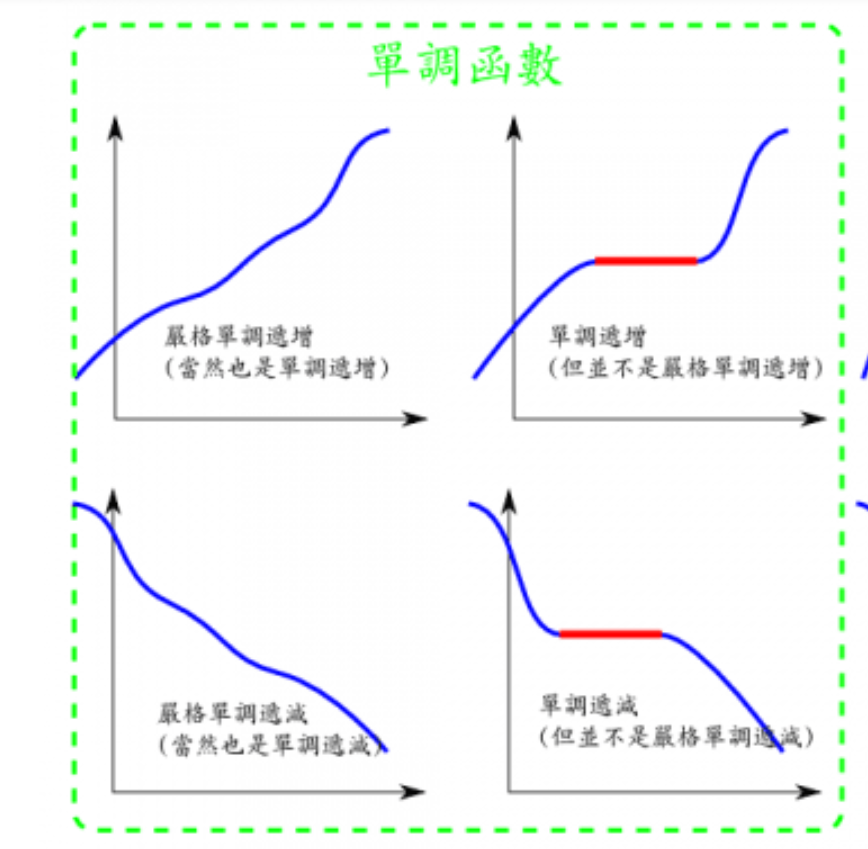

In [38]:
correlation_pearson = df_extreme_return_EPU['平均報酬率'].corr(df_extreme_return_EPU['EPU數量_廣義'],method="pearson")
correlation_spearman = df_extreme_return_EPU['平均報酬率'].corr(df_extreme_return_EPU['EPU數量_廣義'],method="spearman")

print(f"相關係數: {correlation_pearson:.4f}")
print(f"相關係數: {correlation_spearman:.4f}")

相關係數: -0.1014
相關係數: -0.0909


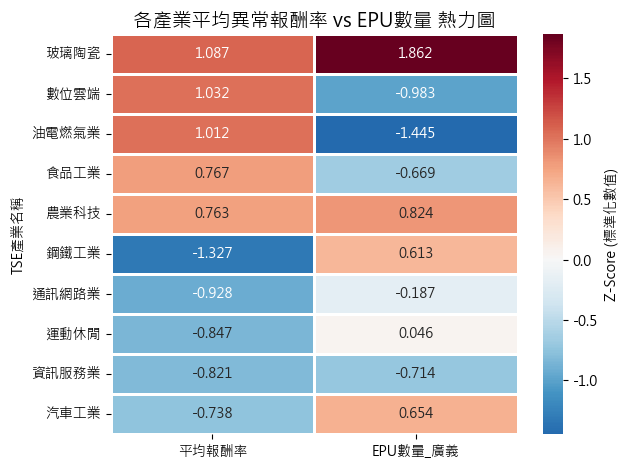

In [35]:
import matplotlib.pyplot as plt
df_norm = (df_extreme_return_EPU - df_extreme_return_EPU.mean()) / df_extreme_return_EPU.std()
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False # 解決負號無法顯示的問題

sns.heatmap(df_norm, 
            annot=df_norm,           # 在格子裡顯示「原始數值」
            fmt=".3f",          # 數值格式：小數點後3位
            cmap="RdBu_r",      # 色票：紅藍配色 (Red-Blue reversed)，紅色代表高值
            center=0,           # 將顏色中心點設為 0 (平均值)
            linewidths=1,       # 格子邊框寬度
            cbar_kws={'label': 'Z-Score (標準化數值)'} # 色條標籤
           )

plt.title("各產業平均異常報酬率 vs EPU數量 熱力圖", fontsize=14)
plt.yticks(rotation=0) # 讓y軸文字轉正
plt.tight_layout()
plt.show()

#### 用OLS模型進行迴歸分析
#### 模組使用 : statsmodels
#### e.g : 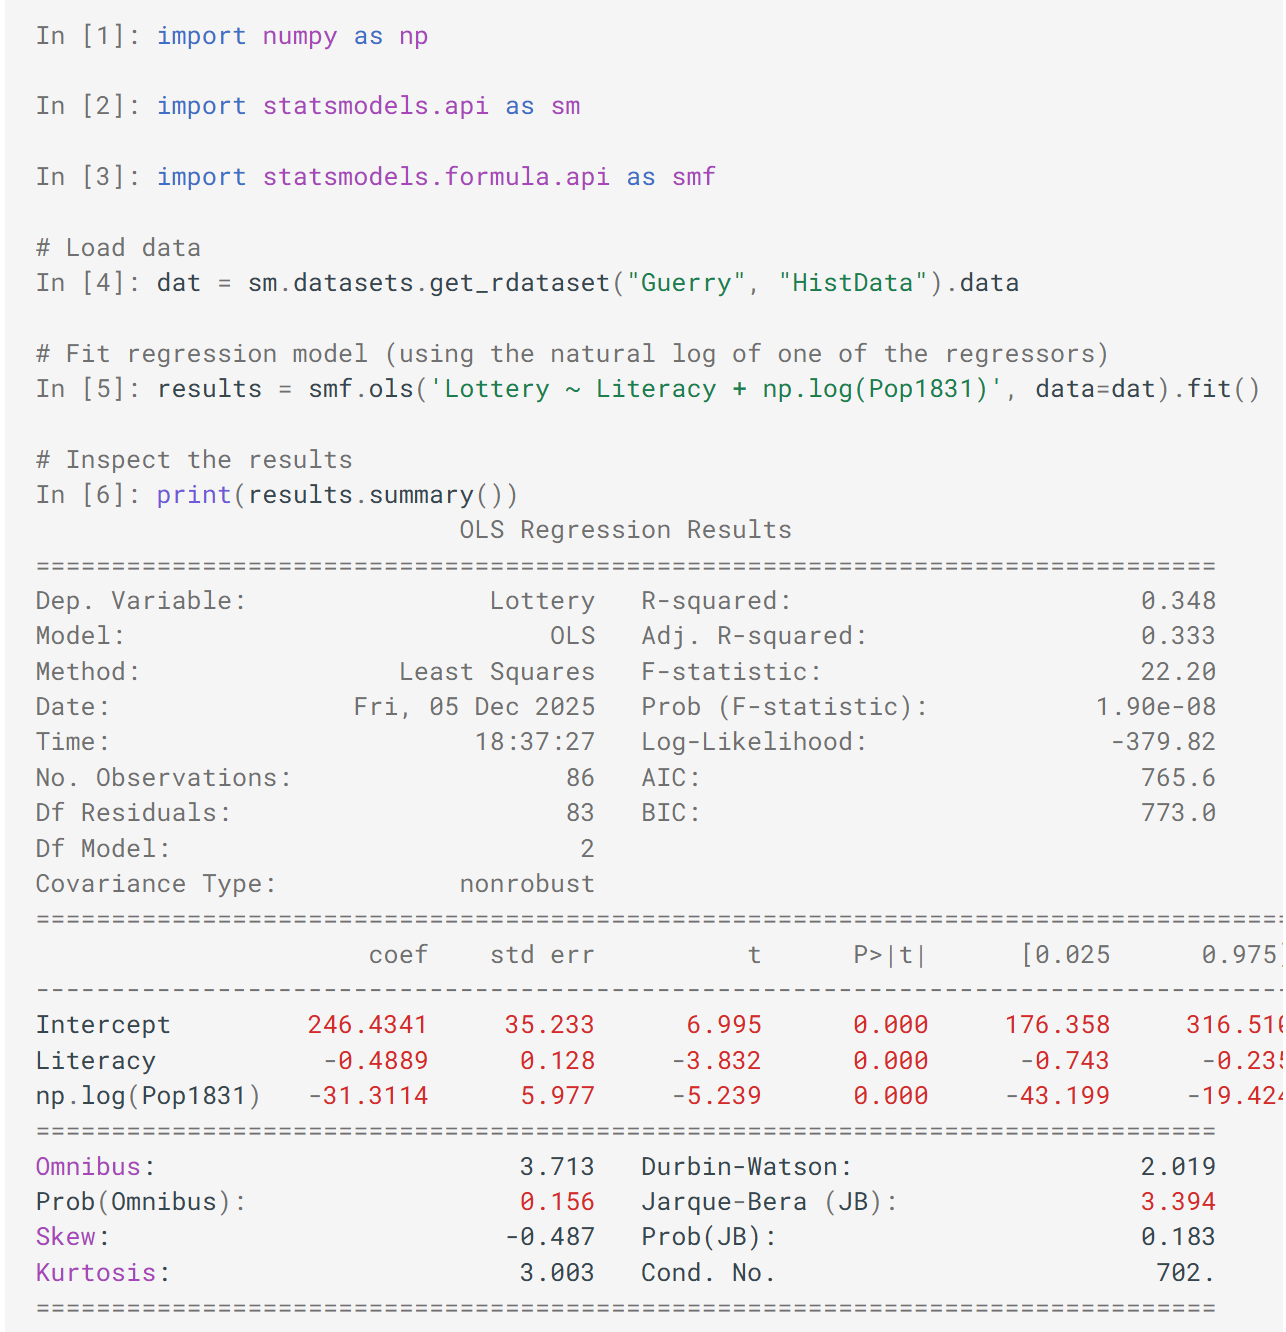

### <span style= "color : #a6440e"> 統計結果 : 顯著 ( p-value = 0.044 < 5% ) </span>
### 95% 信賴區間 -->  -0.097 ~ -0.002  
### coef = -0.0495 --> EPU每上升1單位，報酬率降低4.95%
### 跟熱力圖結果不同原因 : 排除outlier , 例如玻璃陶瓷產業 --> 事件期間內可能受其他非系統風險因素的影響  

In [46]:
# Y=應變數 , X =自變數
import statsmodels.api as sm
x=df_extreme_return_EPU["EPU數量_廣義"]
y=df_extreme_return_EPU["平均報酬率"]
X_const = sm.add_constant(x)
model=sm.OLS(y,x).fit()

print(f"--- OLS 迴歸分析結果 ---")
 # 只印出係數表
print(model.summary().tables[1])
print(model.summary().tables[2])
print("-" * 30)


--- OLS 迴歸分析結果 ---
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
EPU數量_廣義      -0.0495      0.021     -2.339      0.044      -0.097      -0.002
Omnibus:                        1.299   Durbin-Watson:                   0.700
Prob(Omnibus):                  0.522   Jarque-Bera (JB):                0.814
Skew:                           0.353   Prob(JB):                        0.666
Kurtosis:                       1.793   Cond. No.                         1.00
------------------------------


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [ ]:
stat_outcome=pd.read_html(model.summary().tables[1].as_html(),header=0, index_col=0)[0]
stat_outcome.to_csv("EPU_累計報酬率_extreme5.csv",encoding='utf-8-sig')

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)
C:\Users\user\AppData\Local\Temp\ipykernel_15820\356073118.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat_outcome=pd.read_html(model.summary().tables[1].as_html(),header=0, index_col=0)[0]


#### 用pairplot觀察變數之間的關係

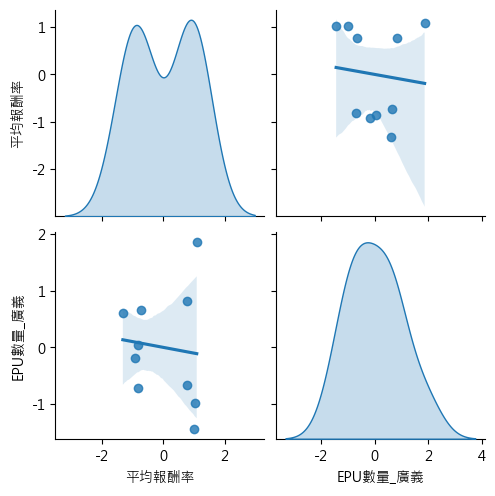

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df_norm,
             kind="reg", 
             diag_kind="kde",
             height=2.5)

#### 擴大樣本 : 檢視所有產業下 EPU 與市場表現(累計報酬率)之關聯

In [23]:
if "Unnamed: 182" in return_industry.columns:
    return_industry=return_industry.drop(columns="Unnamed: 182")

elif "產業平均值" in return_industry.columns:
    return_industry=return_industry.drop(columns="產業平均值")

return_industry["產業累計報酬率"]=return_industry.sum(axis=1)

In [29]:
df_fs_EPU=df_fs_return.groupby("TSE產業名稱")["EPU數量_廣義"].mean()
df_return_EPU=pd.concat([return_industry["產業累計報酬率"],df_fs_EPU],axis=1)
df_norm_allIndus=(df_return_EPU-df_return_EPU.mean())/df_return_EPU.std()

✅ 圖表已儲存為：EPU_cumabReturn_industry.png


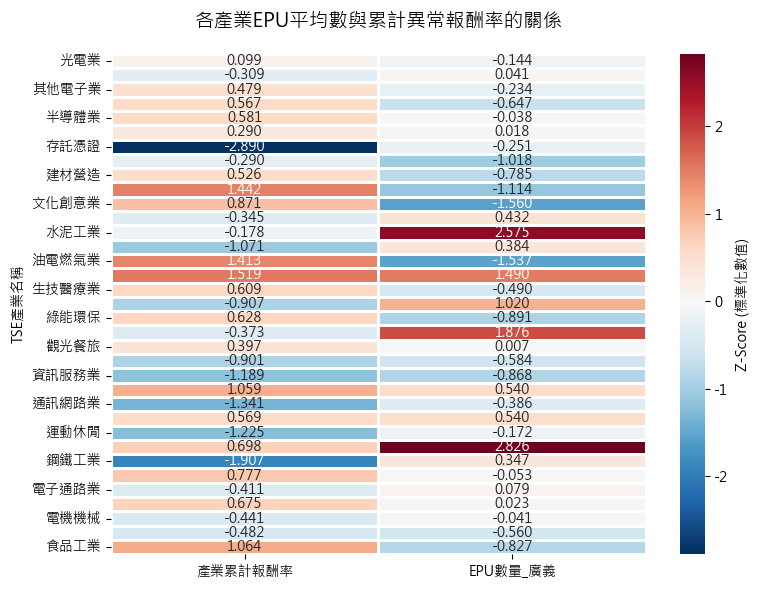

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
def plot_zscore_heatmap(df, title, figsize=(8, 6), output_filename=None):
    """
    繪製「標準化熱力圖」：顏色代表 Z-Score (相對強弱)，數字代表原始數值。
    
    參數:
    ----------
    df : pd.DataFrame
        原始資料 (index 為產業名稱，columns 為變數)。
    title : str
        圖表標題。
    figsize : tuple
        圖表大小 (寬, 高)。
    output_filename : str (選填)
        若提供檔名 (如 'heatmap.png')，會自動儲存圖片。
    """
    
    # 1. 字型設定 (確保中文顯示正常)
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
    plt.rcParams['axes.unicode_minus'] = False

    # 2. 計算 Z-Score 標準化 (用於決定顏色深淺)
    # 公式：(數值 - 平均值) / 標準差
    df_norm = (df - df.mean()) / df.std()

    # 3. 建立畫布
    plt.figure(figsize=figsize)

    # 4. 繪製熱力圖
    sns.heatmap(
        df_norm,           # 資料來源 (決定顏色)：使用標準化後的 Z-Score
        annot=df,          # 格子數字 (決定內容)：使用 df (原始數值)，方便閱讀真實數據
        fmt=".3f",         # 數值格式：小數點後3位
        cmap="RdBu_r",     # 色票：紅藍配色
        center=0,          # 顏色中心點設為 0
        linewidths=1,      # 格子邊框寬度
        cbar_kws={'label': 'Z-Score (標準化數值)'} # 色條標籤
    )

    # 5. 設定標題與軸標籤
    plt.title(title, fontsize=14, pad=20) # pad 增加標題與圖的距離
    plt.yticks(rotation=0) # 讓 y 軸產業名稱轉正
    plt.tight_layout()     # 自動調整版面，避免文字被切掉

    # 6. 存檔與顯示
    if output_filename:
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        print(f"✅ 圖表已儲存為：{output_filename}")

    plt.show()

plot_zscore_heatmap(df_norm_allIndus, title="各產業EPU平均數與累計異常報酬率的關係", figsize=(8, 6), output_filename="EPU_cumabReturn_industry.png")

In [32]:
import statsmodels.api as sm
x_allIndus=df_return_EPU["EPU數量_廣義"]
y_allIndus=df_return_EPU["產業累計報酬率"]
X_const_allIndus = sm.add_constant(x_allIndus)
model_allIndus=sm.OLS(y_allIndus,x_allIndus).fit()

print(f"--- OLS 迴歸分析結果 ---")
 # 只印出係數表
print(model_allIndus.summary().tables[1])

--- OLS 迴歸分析結果 ---
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
EPU數量_廣義      -5.4570      0.980     -5.570      0.000      -7.448      -3.466


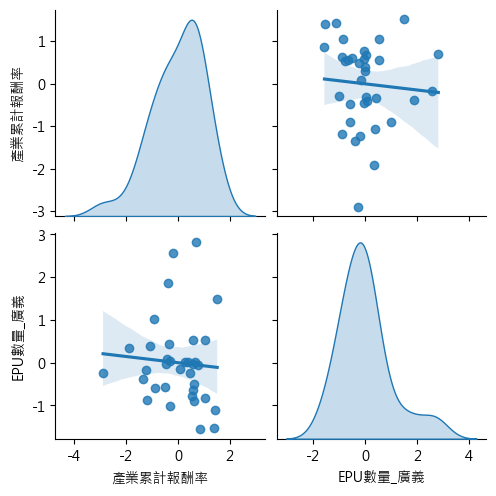

In [48]:

import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df_norm_allIndus,
             kind="reg", 
             diag_kind="kde",
             height=2.5)

### 下圖顯示 : 當相關係數=0時 ， 發生機率幾近為0 

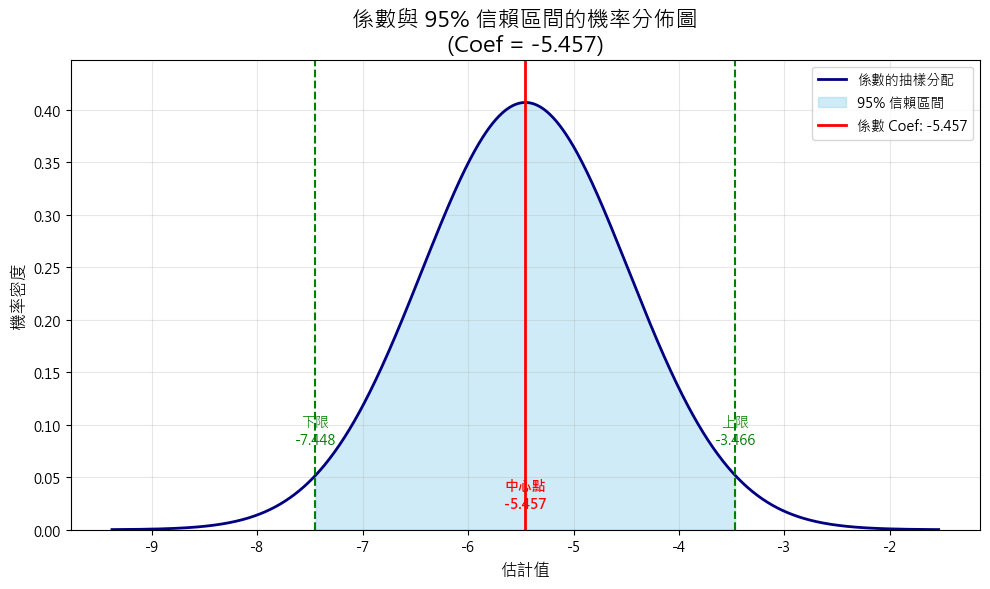

In [56]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# 1. 設定數據 (來自您的 OLS 截圖)
coef = -5.4570       # 係數 (分佈的中心)
std_err = 0.980      # 標準誤 (分佈的胖瘦/標準差)
ci_lower = -7.448    # 信賴區間下限
ci_upper = -3.466    # 信賴區間上限

# 2. 設定畫布與字型
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 6))

# 3. 產生 X 軸數據 (以係數為中心，往左右各延伸 4 倍標準誤)
x = np.linspace(coef - 4*std_err, coef + 4*std_err, 1000)
# 產生 Y 軸數據 (常態分佈機率密度函數)
y = stats.norm.pdf(x, coef, std_err)

# 4. 繪製鐘形曲線
plt.plot(x, y, label='係數的抽樣分配', color='navy', lw=2)

# 5. 繪製信賴區間 (95% 信心水準)
plt.fill_between(x, y, where=(x >= ci_lower) & (x <= ci_upper), 
                 color='skyblue', alpha=0.4, label='95% 信賴區間')

# 6. 標示關鍵位置
# A. 係數 (中心點)
plt.axvline(x=coef, color='red', linestyle='-', lw=2, label=f'係數 Coef: {coef}')
plt.text(coef, max(y)*0.05, f'中心點\n{coef}', color='red', ha='center', fontweight='bold')

# B. 信賴區間下限
plt.axvline(x=ci_lower, color='green', linestyle='--', lw=1.5)
plt.text(ci_lower, max(y)*0.2, f'下限\n{ci_lower}', color='green', ha='center')

# C. 信賴區間上限
plt.axvline(x=ci_upper, color='green', linestyle='--', lw=1.5)
plt.text(ci_upper, max(y)*0.2, f'上限\n{ci_upper}', color='green', ha='center')

# 7. 圖表修飾
plt.title(f'係數與 95% 信賴區間的機率分佈圖\n(Coef = {coef})', fontsize=16)
plt.xlabel('估計值', fontsize=12)
plt.ylabel('機率密度', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.ylim(0, max(y)*1.1)

plt.tight_layout()
plt.show()

#### 將產業樣本拆分成AI產業與非AI產業